In [1]:
# download and explore parquets datasets from FourSquare
import pandas as pd
import glob
import os
import pyarrow.parquet as pq
import unidecode
import numpy as np
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
import torch
from sentence_transformers import SimilarityFunction


C:\Users\lilou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Upload the category datasets

In [13]:
# Load the cleaned OSM categories DataFrame from CSV
df_osm = pd.read_csv('Database/Clean_categories/categories_OSM_clean.csv', sep=';')

# Load the cleaned FS categories DataFrame from CSV
df_fs = pd.read_csv('Database/Clean_categories/categories_FS_clean.csv', sep=';')

# Load the cleaned FS categories with descriptions DataFrame from CSV
df_fs_desc = pd.read_csv('Database/Clean_categories/categories_FS_clean_description.csv', sep=';')

# Load the oracle DataFrame from CSV
df_oracle = pd.read_csv('df_oracle.csv', sep=";")

# Cleaning

In [14]:
# Define the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text: lowercase, remove accents, punctuation, and stopwords
def clean_text(text):
    if text is None or pd.isna(text):  # Preserve None or NaN
        return None
    
    text = str(text).lower()                        # Convert to lowercase
    text = unidecode.unidecode(text)                # Remove accents
    text = re.sub(r'[^\w\s]', '', text)            # Remove punctuation
    words = text.split()                            # Split text into words
    words = [word for word in words if word not in stop_words]  # Filter stopwords
    return ' '.join(words)

# Apply cleaning to OSM and FS tags in the oracle DataFrame
df_oracle['OSM_tag'] = df_oracle['OSM_tag'].apply(clean_text)
df_oracle['FS_tag'] = df_oracle['FS_tag'].apply(clean_text)

# Apply cleaning to OSM DataFrame
df_osm['Tag'] = df_osm['Tag'].apply(clean_text)
df_osm['token_Description'] = df_osm['Description'].apply(clean_text)
df_osm['Depth_1'] = df_osm['Depth_1'].apply(clean_text)
df_osm['Depth_2'] = df_osm['Depth_2'].apply(clean_text)
df_osm['Depth_3'] = df_osm['Depth_3'].apply(clean_text)

# Apply cleaning to FS categories DataFrame
df_fs['Tag'] = df_fs['Tag'].apply(clean_text)
df_fs['Depth_1'] = df_fs['Depth_1'].apply(clean_text)
df_fs['Depth_2'] = df_fs['Depth_2'].apply(clean_text)
df_fs['Depth_3'] = df_fs['Depth_3'].apply(clean_text)
df_fs['Depth_4'] = df_fs['Depth_4'].apply(clean_text)
df_fs['Depth_5'] = df_fs['Depth_5'].apply(clean_text)
df_fs['Depth_6'] = df_fs['Depth_6'].apply(clean_text)

# Apply cleaning to FS categories + description DataFrame
df_fs_desc['Tag'] = df_fs_desc['Tag'].apply(clean_text)
df_fs_desc['Depth_1'] = df_fs_desc['Depth_1'].apply(clean_text)
df_fs_desc['Depth_2'] = df_fs_desc['Depth_2'].apply(clean_text)
df_fs_desc['Depth_3'] = df_fs_desc['Depth_3'].apply(clean_text)
df_fs_desc['Depth_4'] = df_fs_desc['Depth_4'].apply(clean_text)
df_fs_desc['Depth_5'] = df_fs_desc['Depth_5'].apply(clean_text)
df_fs_desc['Depth_6'] = df_fs_desc['Depth_6'].apply(clean_text)
df_fs_desc = df_fs_desc.rename(columns={"definition_en": "Description"})
df_fs_desc['token_Description'] = df_fs_desc['Description'].apply(clean_text)

# Assign cleaned DataFrames to new variables
df_osm_clean = df_osm
df_fs_clean = df_fs
df_fs_desc_clean = df_fs_desc


# Adding columns for analysis

In [29]:
# Create a column in each dataset containing all information about the POI

# Concatenate relevant OSM columns into a single string
def concat_columns_osm(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'token_Description']:
        val = row[col]
        if val is not None and pd.notna(val):  # Ignore None and NaN
            parts.append(str(val))
    return ' '.join(parts)

# Concatenate FS category columns into a single string
def concat_columns_fs(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', "Depth_5", "Depth_6"]:
        val = row[col]
        if val is not None and pd.notna(val):  # Ignore None and NaN
            parts.append(str(val))
    return ' '.join(parts)

# Concatenate FS description columns including the description into a single string
def concat_columns_fs_desc(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', "Depth_5", "Depth_6", "token_Description"]:
        val = row[col]
        if val is not None and pd.notna(val):  # Ignore None and NaN
            parts.append(str(val))
    return ' '.join(parts)

# Apply the functions to create full info columns
df_osm['full_info'] = df_osm.apply(concat_columns_osm, axis=1)
df_fs_desc['full_info_and_desc'] = df_fs_desc.apply(concat_columns_fs_desc, axis=1)
df_fs_desc['full_info'] = df_fs_desc.apply(concat_columns_fs, axis=1)


# Create a column in each dataset containing the POI's path in the category hierarchy

# Concatenate OSM depths into a path string
def concat_depths_osm(row):
    levels = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3']:
        val = row[col]
        if pd.notna(val) and val is not None and str(val).strip() != '':
            levels.append(str(val).strip())
    return ' > '.join(levels)

df_osm['Path'] = df_osm.apply(concat_depths_osm, axis=1)

# Concatenate FS depths into a path string
def concat_depths_fs(row):
    levels = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', "Depth_5", "Depth_6"]:
        val = row[col]
        if pd.notna(val) and val is not None and str(val).strip() != '':
            levels.append(str(val).strip())
    return ' > '.join(levels)

# df_fs['Path'] = df_fs.apply(concat_depths_fs, axis=1)
df_fs_desc['Path'] = df_fs_desc.apply(concat_depths_fs, axis=1)


df_osm["full_info_set"] = df_osm["full_info"].apply(
    lambda x: " ".join(dict.fromkeys(x.split()))
)

# Matching

In [30]:
# Load various pre-trained SentenceTransformer models
model_1 = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # fast
model_2 = SentenceTransformer('all-MiniLM-L6-v2')         # fast
model_3 = SentenceTransformer('all-distilroberta-v1')     
model_4 = SentenceTransformer('all-mpnet-base-v2')        # ~6 min
model_5 = SentenceTransformer('paraphrase-mpnet-base-v2') # ~4 min
model_6 = SentenceTransformer('paraphrase-distilroberta-base-v2') # ~4 min
model_7 = SentenceTransformer('paraphrase-TinyBERT-L6-v2')
model_8 = SentenceTransformer('all-MiniLM-L12-v2')


# Function to compute matches between OSM and FS descriptions using sentence embeddings
def make_matchs(model, model_name, description_osm, description_fs, df_osm, df_fs_desc, desc_fs = ""):

    # Use cosine similarity for comparing embeddings
    model.similarity_fn_name = SimilarityFunction.COSINE

    # Generate embeddings for OSM descriptions
    print("-- beginning embedding 1")
    embeddings_1 = model.encode(description_osm, convert_to_tensor=True)  # Each row represents a sentence vector
    print("-- end embedding 1")

    # Generate embeddings for FS descriptions
    print("-- beginning embedding 2")
    embeddings_2 = model.encode(description_fs, convert_to_tensor=True)  # PyTorch tensor for faster similarity calculation
    print("-- end embedding 2")

    # Compute cosine similarity between embeddings: 1 = identical, 0 = orthogonal, -1 = opposite
    similarity_score = model.similarity(embeddings_1, embeddings_2)

    matches = []

    # Iterate over each OSM row to find the best matching FS row
    for idx1, row1 in df_osm.iterrows():
        best_idx2 = torch.argmax(similarity_score[idx1]).item()        # Index of the FS row with highest similarity
        best_score = similarity_score[idx1][best_idx2].item()          # Best similarity score
        
        row2 = df_fs_desc.iloc[best_idx2]                              # Retrieve the corresponding FS row
        
        matches.append({
            #'OSM_index': idx1,
            'OSM_tag': row1['Tag'],
            'OSM_description': row1['Description'],
            'OSM_path': row1['Path'],
            
            #'matched_FS_index': best_idx2,
            'FS_tag_match': row2['Tag'],
            'FS_description': row2['Description'], 
            'FS_path_match': row2['Path'],

            'similarity_score': best_score
        })

    # Convert the matches to a DataFrame and sort by similarity score descending
    matches_df = pd.DataFrame(matches).sort_values(by='similarity_score', ascending=False)
    # matches_df.to_csv(f"{desc_fs}_{model_name}.csv", index=False, sep=";")

    # Convert similarity tensor to numpy array
    matrix_score = similarity_score.detach().cpu().numpy()  # Shape: (num_OSM, num_FS)

    return matches_df, matrix_score


In [32]:
# List of models with their names
models = [
    (model_1, 'paraphrase-MiniLM-L6-v2'),
    (model_2, 'all-MiniLM-L6-v2'),
    (model_3, 'all-distilroberta-v1'),  # too slow
    (model_4, 'all-mpnet-base-v2'),
    (model_5, 'paraphrase-mpnet-base-v2'),
    (model_6, 'paraphrase-distilroberta-base-v2'),
    (model_7, 'paraphrase-TinyBERT-L6-v2'),
    (model_8, 'all-MiniLM-L12-v2')
]

# Extract OSM descriptions into lists
description_osm = df_osm["Description"].tolist()         
full_info_set_osm = df_osm["Description"].tolist()       # extract as list

# Extract full OSM info including all concatenated fields
full_info_osm = df_osm["full_info_set"].tolist()         

# Extract FS descriptions and full info lists
description_fs = df_fs_desc["Description"].tolist()
full_info_without_description_fs = df_fs_desc["full_info"].tolist()
full_info_with_description_fs = df_fs_desc["full_info_and_desc"].tolist()

# Make a copy of the oracle dataframe for comparison
df_compare = df_oracle.copy()

In [33]:
# Dictionaries to store the similarity score matrices for each model
all_scores_FI = {}   # For full info without FS description
all_scores_FID = {}  # For full info with FS description

# --------------------------
# Full info without FS description
i = 1
for model, model_name in models:
    print(f"-🪴model {i}: {model_name}")
    # Compute matches and similarity matrix
    df_match, matrix_score = make_matchs(
        model, model_name, 
        full_info_osm, 
        full_info_without_description_fs, 
        df_osm, df_fs_desc, 
        desc_fs="DF"
    )

    # Store the score matrix
    all_scores_FI[f"mod_{i}"] = matrix_score  # or .tolist() if preferred

    # Merge with df_compare to get the best FS_tag_match
    df_compare = pd.merge(
        df_compare, 
        df_match[["OSM_tag", "OSM_path", "FS_tag_match", 'similarity_score']], 
        on=['OSM_tag', 'OSM_path'], 
        how='left'
    )
    
    # Create a column indicating if the predicted FS tag matches the manual FS tag
    df_compare[f'mod_{i}_FI_correct'] = (df_compare['FS_tag'] == df_compare['FS_tag_match']).astype(int)
    
    # Rename columns to keep track of model and scenario
    df_compare = df_compare.rename(columns={
        "similarity_score": f"mod_{i}_FI_ss", 
        "FS_tag_match": f"mod_{i}_FI_tag"
    })
    i += 1

# --------------------------
# Full info with FS description
i = 1
for model, model_name in models:
    print(f"-🪴model {i}: {model_name}")
    # Compute matches and similarity matrix
    df_match, matrix_score = make_matchs(
        model, model_name, 
        full_info_osm, 
        full_info_with_description_fs, 
        df_osm, df_fs_desc, 
        desc_fs="DF"
    )

    # Store the score matrix
    all_scores_FID[f"mod_{i}"] = matrix_score

    # Merge with df_compare to get the best FS_tag_match
    df_compare = pd.merge(
        df_compare, 
        df_match[["OSM_tag", "OSM_path", "FS_tag_match", 'similarity_score']], 
        on=['OSM_tag', 'OSM_path'], 
        how='left'
    )
    
    # Create a column indicating if the predicted FS tag matches the manual FS tag
    df_compare[f'mod_{i}_FID_correct'] = (df_compare['FS_tag'] == df_compare['FS_tag_match']).astype(int)
    
    # Rename columns to keep track of model and scenario
    df_compare = df_compare.rename(columns={
        "similarity_score": f"mod_{i}_FID_ss", 
        "FS_tag_match": f"mod_{i}_FID_tag"
    })
    i += 1

# Optionally save the dataframe with all scores and correctness indicators
# df_compare.to_csv("embedding/embedding_models_cosinus_score_FI_FID.csv", index=False, sep=";")

-🪴model 1: paraphrase-MiniLM-L6-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 2: all-MiniLM-L6-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 3: all-distilroberta-v1
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 4: all-mpnet-base-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 5: paraphrase-mpnet-base-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 6: paraphrase-distilroberta-base-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 7: paraphrase-TinyBERT-L6-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 8: all-MiniLM-L12-v2
-- beginning embedding 1
-- end embedding 1
-- beginning embedding 2
-- end embedding 2
-🪴model 1: paraphrase-Mini

# Compare embeddings using inputs with and without FS descriptions

In [ ]:
#df_compare = pd.read_csv("embedding/embedding_models_cosinus_score_FI_FID.csv", sep=";")
#df_compare = df_compare.rename(columns={"FS_tag":"FS_manual_tag"})

In [34]:
# Function to concatenate all depth levels into a single FS path
def concat_depths_fs(row):
    levels = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', "Depth_5", "Depth_6"]:
        val = row[col]
        if pd.notna(val) and val is not None and str(val).strip() != '':
            levels.append(str(val).strip())
    return ' > '.join(levels)

# Apply the function to create a 'Path' column in the FS dataframe
df_fs['Path'] = df_fs.apply(concat_depths_fs, axis=1)

# Build a dictionary mapping FS tag -> full path
tag_to_path = dict(zip(df_fs["Tag"], df_fs["Path"]))

# For each predicted FS tag column (FID models), create a corresponding path column
for i in range(1, 9):
    tag_col = f"mod_{i}_FID_tag"
    path_col = f"mod_{i}_FID_path"
    
    # Map the tag to its full FS path
    df_compare[path_col] = df_compare[tag_col].map(tag_to_path)
    
# For each predicted FS tag column (FI models), create a corresponding path column
for i in range(1, 9):
    tag_col = f"mod_{i}_FI_tag"
    path_col = f"mod_{i}_FI_path"
    
    # Map the tag to its full FS path
    df_compare[path_col] = df_compare[tag_col].map(tag_to_path)

In [35]:
# Loop over FI model predictions to create a new correctness column
for i in range(1, 9):  # 8 FI models
    col_pred = f"mod_{i}_FI_tag"          # predicted FS tag
    col_true = "FS_tag"                    # true FS tag from oracle
    col_new_correct = f"mod_{i}_FI_new_correct"  # new correctness column
    col_path = f"mod_{i}_FI_path"         # full predicted path in format "main > sub > tag"

    # Function to check if prediction is correct
    # Either exact match with true tag or true tag is in the predicted path
    def is_in_path(row):
        if pd.isna(row[col_pred]) or pd.isna(row[col_true]):
            return False
        path_parts = [p.strip() for p in row[col_path].split(">")] if pd.notna(row[col_path]) else []
        return (row[col_pred] == row[col_true]) or (row[col_true] in path_parts)

    # Apply the function and store results as int (0/1)
    df_compare[col_new_correct] = df_compare.apply(is_in_path, axis=1).astype(int)


# Loop over FID model predictions to create a new correctness column
for i in range(1, 9):  # 8 FID models
    col_pred = f"mod_{i}_FID_tag"          # predicted FS tag
    col_true = "FS_tag"                     # true FS tag from oracle
    col_new_correct = f"mod_{i}_FID_new_correct"  # new correctness column
    col_path = f"mod_{i}_FID_path"         # full predicted path in format "main > sub > tag"

    # Function to check if prediction is correct
    # Either exact match with true tag or true tag is in the predicted path
    def is_in_path(row):
        if pd.isna(row[col_pred]) or pd.isna(row[col_true]):
            return False
        path_parts = [p.strip() for p in row[col_path].split(">")] if pd.notna(row[col_path]) else []
        return (row[col_pred] == row[col_true]) or (row[col_true] in path_parts)
    
    # Apply the function and store results as int (0/1)
    df_compare[col_new_correct] = df_compare.apply(is_in_path, axis=1).astype(int)

In [36]:
# Create a list of composite keys for OSM: (Tag, Path)
osm_keys = list(zip(df_osm['Tag'], df_osm['Path']))  
fs_tags = list(df_fs['Tag'])  # List of FS tags

# Number of OSM entries and FS tags
n_osm, n_fs = len(osm_keys), len(fs_tags)

# Initialize a zero matrix: rows = OSM, columns = FS tags
y_true = np.zeros((n_osm, n_fs), dtype=int)

# Dictionary mapping FS tag to its column index
fs_tag_to_idx = {tag: idx for idx, tag in enumerate(fs_tags)}

# Dictionary mapping OSM composite key to its row index
osm_key_to_idx = {key: idx for idx, key in enumerate(osm_keys)}

# Fill the matrix with 1 where the OSM tag corresponds to the FS tag
for _, row in df_oracle.iterrows():
    osm_key = (row['OSM_tag'], row.get('OSM_path', None))
    fs_tag = row['FS_tag']
    
    i = osm_key_to_idx.get(osm_key)  # row index
    j = fs_tag_to_idx.get(fs_tag)    # column index
    
    if i is not None and j is not None:
        y_true[i, j] = 1  # mark as a match

# Print the total number of matches, should be 1205
print("Total number of 1s:", y_true.sum())

Total number of 1s: 1205


In [37]:
# Print the shape of the similarity score matrix: should be (number of OSM entries, number of FS tags)
print(matrix_score.shape)   # expected: (n_osm, n_fs)

# Print the shape of the ground-truth matrix: should match matrix_score
print(y_true.shape)         # expected: same as matrix_score

# Print the number of FS paths: should match n_fs
print(len(df_fs['Path']))  # expected: n_fs

# Print the number of OSM paths: should match n_osm
print(len(df_osm['Path'])) # expected: n_osm

(1205, 1244)
(1205, 1244)
1244
1205


In [38]:
def make_best_score_correct_matrix(y_score, y_true, fs_paths):
    """
    Selects the FS (Foursquare) tag with the highest score among all FS tags whose path contains 
    the oracle FS tag.

    y_score: np.array (n_osm, n_fs) - similarity scores from the model
    y_true: np.array (n_osm, n_fs) - 1 if FS is correct for the OSM tag, 0 otherwise (one 1 per row)
    fs_paths: list of FS paths corresponding to the columns
    """
    n_osm, n_fs = y_score.shape
    best_correct_matrix = np.zeros_like(y_true)

    for i in range(n_osm):
        # Get the oracle FS tag for this OSM tag
        correct_idx = np.where(y_true[i] == 1)[0][0]
        correct_tag = fs_paths[correct_idx]

        # Get indices of FS tags whose path contains the oracle FS tag
        correct_indices = [j for j in range(n_fs) if correct_tag in fs_paths[j]]

        if correct_indices:
            # Choose the one with the highest score
            scores_correct = y_score[i, correct_indices]
            best_idx = correct_indices[np.argmax(scores_correct)]
            best_correct_matrix[i, best_idx] = 1  # only the best correct tag is marked as 1

    return best_correct_matrix


def make_all_correct_matrix(y_true, fs_paths):
    """
    Extends the 1 in y_true to all FS tags whose path contains the oracle FS tag.

    y_true: np.array (n_osm, n_fs) - 1 if FS is correct for OSM tag, 0 otherwise (one 1 per row)
    fs_paths: list of FS paths corresponding to the columns
    """
    n_osm, n_fs = y_true.shape
    all_correct_matrix = np.zeros_like(y_true)

    for i in range(n_osm):
        # Find the index of the oracle FS tag (one unique 1)
        correct_idx = np.where(y_true[i] == 1)[0][0]
        correct_tag = fs_paths[correct_idx]

        for j in range(n_fs):
            # Mark all FS tags whose path contains the oracle tag as correct
            if correct_tag in fs_paths[j]:
                all_correct_matrix[i, j] = 1

    return all_correct_matrix

In [39]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Mapping model keys to their human-readable names
model_names = {
    "mod_1": 'paraphrase-MiniLM-L6-v2',
    "mod_2": 'all-MiniLM-L6-v2',
    "mod_3": 'all-distilroberta-v1',
    "mod_4": 'all-mpnet-base-v2',
    "mod_5": 'paraphrase-mpnet-base-v2',
    "mod_6": 'paraphrase-distilroberta-base-v2',
    "mod_7": 'paraphrase-TinyBERT-L6-v2',
    "mod_8": 'all-MiniLM-L12-v2',
}

def create_summary(df, suffix, all_scores, y_true, fs_paths, osm_tags):
    """
    Generates a summary table for all models for either FI (full info) or FID (full info + description).

    df: DataFrame containing predicted correctness columns
    suffix: 'FI' or 'FID' (to select correct columns, "FI": full information (so without description), "FID": full information + descri)
    all_scores: dictionary of score matrices for each model
    y_true: binary oracle matrix (1 if FS correct for OSM tag)
    fs_paths: list of FS paths for each FS column
    osm_tags: list of OSM tags for each row
    """
    summary = []
    for i in range(1, 27):  # 26 models (or keys)
        mod_key = f"mod_{i}"
        col_correct = f"{mod_key}_{suffix}_correct"
        col_new_correct = f"{mod_key}_{suffix}_new_correct"
        col_ss = f"{mod_key}_{suffix}_ss"

        if col_correct not in df.columns:
            continue  # skip if the column doesn’t exist

        # Compute percentages
        pct_correct = df[col_correct].mean() * 100
        pct_new_correct = df[col_new_correct].mean() * 100

        # Retrieve the score matrix and compute best_correct_matrix
        if mod_key in all_scores:
            score_matrix = all_scores[mod_key]
            best_correct_matrix = make_best_score_correct_matrix(
                y_score=score_matrix,
                y_true=y_true,
                fs_paths=fs_paths
            )
        else:
            best_correct_matrix = None
            score_matrix = None

        # Compute AUC with the score matrix
        try:
            auc_correct = roc_auc_score(y_true.flatten(), score_matrix.flatten())
        except ValueError:
            auc_correct = None

        try:
            # AUC using the “new_correct” matrix (best match along paths)
            auc_new_correct = roc_auc_score(best_correct_matrix.flatten(), score_matrix.flatten())
        except ValueError:
            auc_new_correct = None

        summary.append({
            f"model {suffix}": model_names.get(mod_key, mod_key),
            "correct_%": pct_correct,
            "AUC": auc_correct,
            "new_correct_%": pct_new_correct,
            "AUC_new": auc_new_correct
        })

    return pd.DataFrame(summary)

# Create summaries for FI and FID
summary_FI = create_summary(df_compare, "FI", all_scores_FI, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist())
summary_FID = create_summary(df_compare, "FID", all_scores_FID, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist())

In [ ]:
# Summary for inputs without description
summary_FI

In [ ]:
# Summary for inputs with description
summary_FID


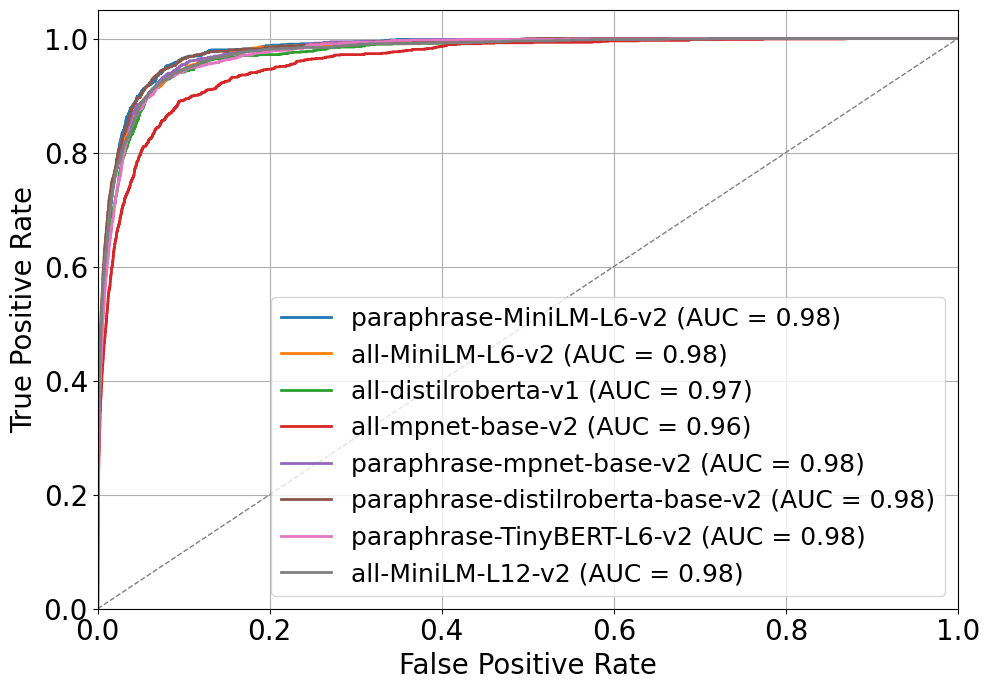

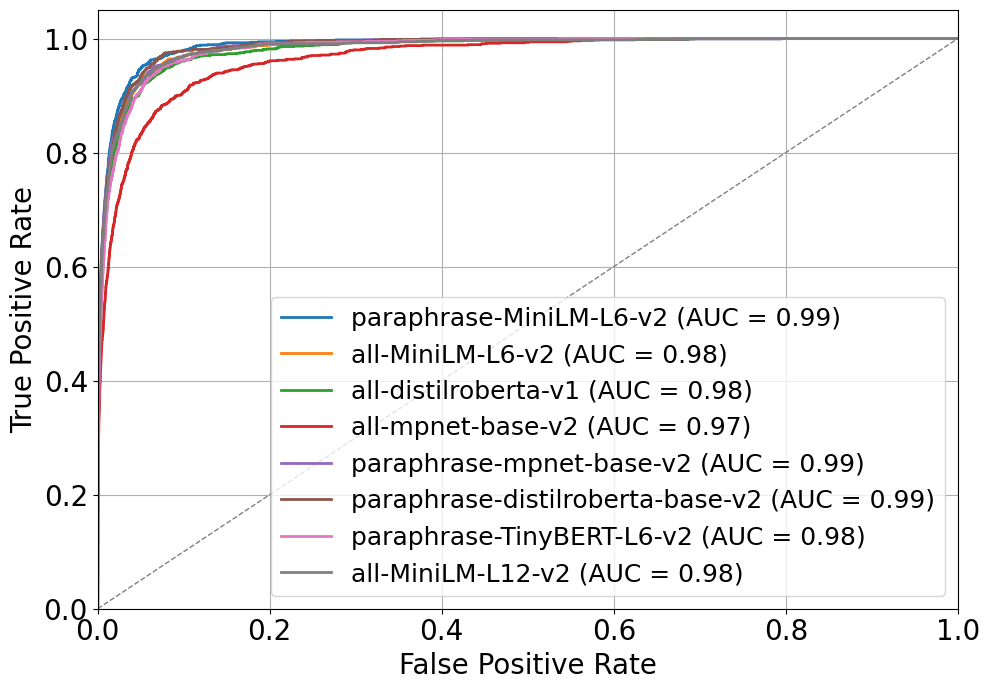

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(all_scores, y_true, fs_paths, osm_tags, suffix, with_or_without):
    """
    Plots ROC curves for all models using the best path-corrected predictions.

    all_scores: dict of model score matrices (n_osm x n_fs)
    y_true: binary oracle matrix
    fs_paths: list of FS paths for each FS column
    osm_tags: list of OSM tags
    suffix: string identifier for the dataset type ('FI' or 'FID')
    with_or_without: descriptive string ('with' or 'without' FS description)
    """
    plt.figure(figsize=(10, 7))

    for i in range(1, 27):  # loop over 26 models
        mod_key = f"mod_{i}"

        if mod_key not in all_scores:
            continue

        # Get the model's score matrix
        score_matrix = all_scores[mod_key]

        # Compute “best correct” matrix for this model
        best_correct_matrix = make_best_score_correct_matrix(
            y_score=score_matrix,
            y_true=y_true,
            fs_paths=fs_paths
        )

        # Flatten matrices for sklearn
        y_true_flat = best_correct_matrix.flatten()   # new_correct
        y_score_flat = score_matrix.flatten()

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f"{model_names.get(mod_key, mod_key)} (AUC = {roc_auc:.2f})")

    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)
    plt.tight_layout()

    # Save figure to PDF
    plt.savefig(f"ROC_simple_model_input_{with_or_without}_FS_description.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Plot ROC curves for FI (Full Info)
plot_roc_curves(all_scores_FI, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist(), "FI", "without")

# Plot ROC curves for FID (Full Info + FS description)
plot_roc_curves(all_scores_FID, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist(), "FID", "with")

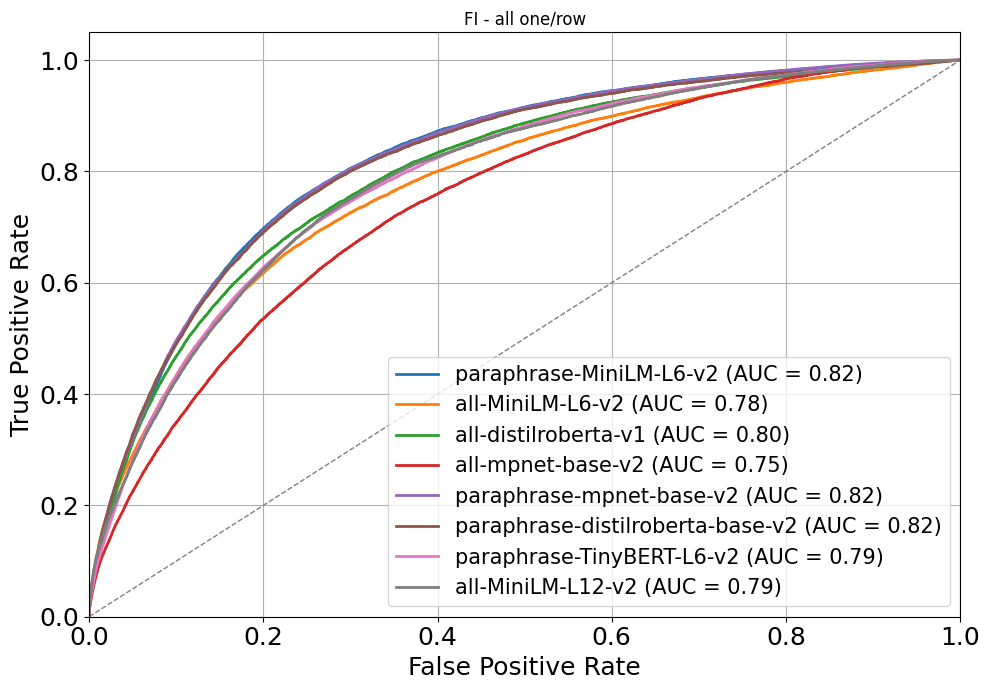

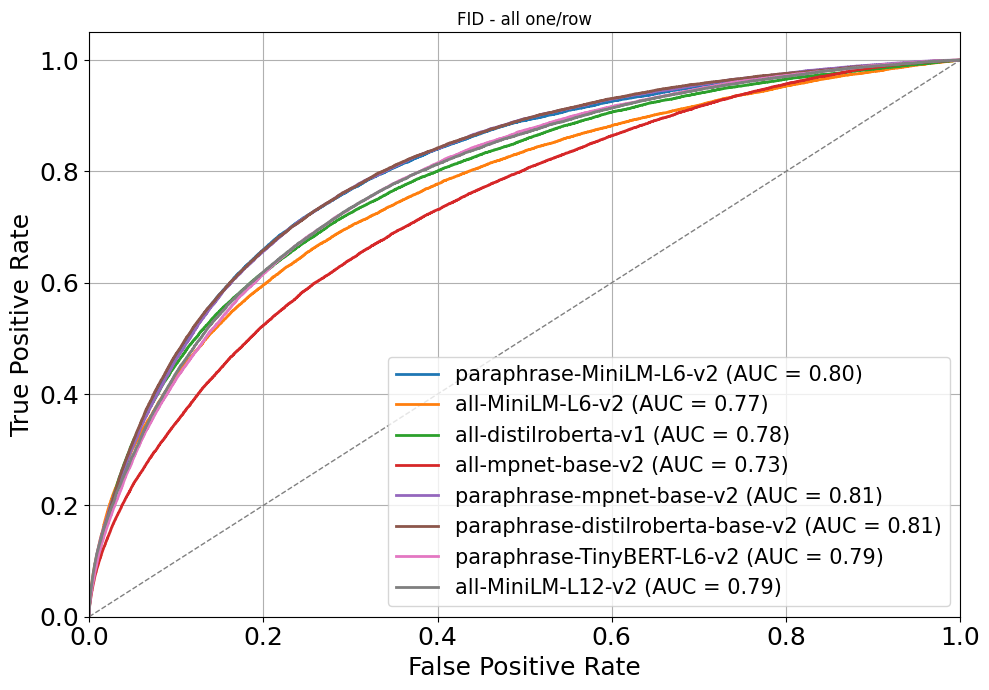

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(all_scores, y_true, fs_paths, osm_tags, suffix, with_or_without):
    """
    Plots ROC curves for all models using the extended “all correct” matrix, 
    which marks 1 for all FS whose path contains the oracle FS.

    all_scores: dict of model score matrices (n_osm x n_fs)
    y_true: binary oracle matrix
    fs_paths: list of FS paths for each FS column
    osm_tags: list of OSM tags
    suffix: string identifier for the dataset type ('FI' or 'FID')
    with_or_without: descriptive string ('with' or 'without' FS description)
    """
    plt.figure(figsize=(10, 7))

    for i in range(1, 27):  # Loop over all 26 models
        mod_key = f"mod_{i}"

        if mod_key not in all_scores:
            continue

        # Get the model's similarity score matrix
        score_matrix = all_scores[mod_key]

        # Compute “all correct” matrix (all FS tags containing the oracle tag in their path)
        best_correct_matrix = make_all_correct_matrix(
            y_true=y_true,
            fs_paths=fs_paths
        )

        # Flatten matrices for sklearn
        y_true_flat = best_correct_matrix.flatten()   # new_correct including all path matches
        y_score_flat = score_matrix.flatten()

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
        roc_auc = auc(fpr, tpr)

        # Plot ROC for this model
        plt.plot(fpr, tpr, lw=2, label=f"{model_names.get(mod_key, mod_key)} (AUC = {roc_auc:.2f})")

    # Diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f"{suffix} - all one/row")
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc="lower right", fontsize=15)
    plt.grid(True)
    plt.tight_layout()

    # Save figure
    plt.savefig(f"ROC_simple_model_input_{with_or_without}_FS_description.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Plot ROC curves for FI (Full Info)
plot_roc_curves(all_scores_FI, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist(), "FI", "without")

# Plot ROC curves for FID (Full Info + FS description)
plot_roc_curves(all_scores_FID, y_true, df_fs['Path'].tolist(), df_osm['Tag'].tolist(), "FID", "with")

# Calculate the percentage of correct predictions within the top-k candidates

In [ ]:
# Load datasets
df_osm = pd.read_csv('C:/Users/lilou/Documents/STAGE-TRENTO/Database/Clean_categories/categories_OSM_clean.csv', sep=';')
df_fs = pd.read_csv('C:/Users/lilou/Documents/STAGE-TRENTO/Database/Clean_categories/categories_FS_clean.csv', sep=';')
df_fs_desc = pd.read_csv('C:/Users/lilou/Documents/STAGE-TRENTO/Database/Clean_categories/categories_FS_clean_description.csv', sep=';')
df_oracle = pd.read_csv('df_oracle.csv', sep=";")

# Set of English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans a text string:
    - returns None for None or NaN values
    - converts to lowercase
    - removes accents
    - removes punctuation
    - removes stopwords
    """
    if text is None or pd.isna(text):
        return None
    
    text = str(text).lower()                        # lowercase
    text = unidecode.unidecode(text)                # remove accents
    text = re.sub(r'[^\w\s]', '', text)            # remove punctuation
    words = text.split()                            # split into words
    words = [word for word in words if word not in stop_words]  # remove stopwords
    return ' '.join(words)

# Clean OSM and FS tags in oracle
df_oracle['OSM_tag'] = df_oracle['OSM_tag'].apply(clean_text)
df_oracle['FS_tag'] = df_oracle['FS_tag'].apply(clean_text)

# Clean OSM dataset
df_osm['Tag'] = df_osm['Tag'].apply(clean_text)
df_osm['token_Description'] = df_osm['Description'].apply(clean_text)
df_osm['Depth_1'] = df_osm['Depth_1'].apply(clean_text)
df_osm['Depth_2'] = df_osm['Depth_2'].apply(clean_text)
df_osm['Depth_3'] = df_osm['Depth_3'].apply(clean_text)

# Clean FS dataset
df_fs['Tag'] = df_fs['Tag'].apply(clean_text)
df_fs['Depth_1'] = df_fs['Depth_1'].apply(clean_text)
df_fs['Depth_2'] = df_fs['Depth_2'].apply(clean_text)
df_fs['Depth_3'] = df_fs['Depth_3'].apply(clean_text)
df_fs['Depth_4'] = df_fs['Depth_4'].apply(clean_text)
df_fs['Depth_5'] = df_fs['Depth_5'].apply(clean_text)
df_fs['Depth_6'] = df_fs['Depth_6'].apply(clean_text)

# Clean FS description dataset
df_fs_desc['Tag'] = df_fs_desc['Tag'].apply(clean_text)
df_fs_desc['Depth_1'] = df_fs_desc['Depth_1'].apply(clean_text)
df_fs_desc['Depth_2'] = df_fs_desc['Depth_2'].apply(clean_text)
df_fs_desc['Depth_3'] = df_fs_desc['Depth_3'].apply(clean_text)
df_fs_desc['Depth_4'] = df_fs_desc['Depth_4'].apply(clean_text)
df_fs_desc['Depth_5'] = df_fs_desc['Depth_5'].apply(clean_text)
df_fs_desc['Depth_6'] = df_fs_desc['Depth_6'].apply(clean_text)
df_fs_desc = df_fs_desc.rename(columns={"definition_en": "Description"})
df_fs_desc['token_Description'] = df_fs_desc['Description'].apply(clean_text)

# Save cleaned datasets
df_osm_clean = df_osm
df_fs_clean = df_fs
df_fs_desc_clean = df_fs_desc

In [ ]:
# Create a column in each dataset that contains all information about the POI
def concat_columns_osm(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'token_Description']:
        val = row[col]
        if val is not None and pd.notna(val):  # Ignore None and NaN
            parts.append(str(val))
    return ' '.join(parts)

def concat_columns_fs(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', 'Depth_5', 'Depth_6']:
        val = row[col]
        if val is not None and pd.notna(val):
            parts.append(str(val))
    return ' '.join(parts)

def concat_columns_fs_desc(row):
    parts = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', 'Depth_5', 'Depth_6', 'token_Description']:
        val = row[col]
        if val is not None and pd.notna(val):
            parts.append(str(val))
    return ' '.join(parts)

# Apply concatenation to create full information columns
df_osm['full_info'] = df_osm.apply(concat_columns_osm, axis=1)
df_fs_desc['full_info_and_desc'] = df_fs_desc.apply(concat_columns_fs_desc, axis=1)
df_fs_desc['full_info'] = df_fs_desc.apply(concat_columns_fs, axis=1)


# Create a column with the full path of the POI in the category hierarchy
def concat_depths_osm(row):
    levels = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3']:
        val = row[col]
        if pd.notna(val) and val is not None and str(val).strip() != '':
            levels.append(str(val).strip())
    return ' > '.join(levels)

df_osm['Path'] = df_osm.apply(concat_depths_osm, axis=1)

def concat_depths_fs(row):
    levels = []
    for col in ['Depth_1', 'Depth_2', 'Depth_3', 'Depth_4', 'Depth_5', 'Depth_6']:
        val = row[col]
        if pd.notna(val) and val is not None and str(val).strip() != '':
            levels.append(str(val).strip())
    return ' > '.join(levels)

# Apply to FS description dataset
df_fs_desc['Path'] = df_fs_desc.apply(concat_depths_fs, axis=1)

# Build a dictionary mapping FS tag -> path
tag_to_path = dict(zip(df_fs_desc["Tag"], df_fs_desc["Path"]))

In [ ]:
def make_matchs_k(model, model_name, description_osm, description_fs, df_osm, df_fs_desc, desc_fs="", k=5):
    model.similarity_fn_name = SimilarityFunction.COSINE  
    
    # Compute embeddings for OSM and FS descriptions
    print("-- beginning embedding OSM")
    embeddings_1 = model.encode(description_osm, convert_to_tensor=True) 
    print("-- end embedding OSM")

    print("-- beginning embedding FS")
    embeddings_2 = model.encode(description_fs, convert_to_tensor=True) 
    print("-- end embedding FS")

    # Cosine similarity between embeddings
    similarity_score = model.similarity(embeddings_1, embeddings_2)

    matches = []

    for idx1, row1 in df_osm.iterrows():
        # Get top-k scores and their indices for this OSM row
        topk_scores, topk_indices = torch.topk(similarity_score[idx1], k)

        # Extract the corresponding FS tags and scores
        topk_tags = df_fs_desc.iloc[topk_indices.tolist()]['Tag'].tolist()
        topk_scores = topk_scores.tolist()

        # Store results
        matches.append({
            'OSM_tag': row1['Tag'],
            'OSM_description': row1['Description'],
            'OSM_path': row1['Path'],
            'FS_topk_tags': topk_tags,
            'FS_topk_scores': topk_scores
        })

    matches_df = pd.DataFrame(matches)
    return matches_df

In [ ]:
# List of models with their names
models = [
    (model_1, 'paraphrase-MiniLM-L6-v2'),
    (model_2, 'all-MiniLM-L6-v2'),
    (model_3, 'all-distilroberta-v1'),  # too long
    (model_4, 'all-mpnet-base-v2'),
    (model_5, 'paraphrase-mpnet-base-v2'),
    (model_6, 'paraphrase-distilroberta-base-v2'),
    (model_7, 'paraphrase-TinyBERT-L6-v2'),
    (model_8, 'all-MiniLM-L12-v2')
]

import pandas as pd

# List of k values to test
k_values = [30, 40, 50]

# Dictionary to store the results, with model names and percentages for each k
results = { "Model": [], **{f"k={k}": [] for k in k_values} }

# Iterate over each model
for model, model_name in models:
    print(model_name)  # print current model name
    results["Model"].append(model_name)
    
    # Iterate over each k value
    for k in k_values:
        print("---", k)  # print current k value
        
        # Generate top-k matches using the model
        df_match = make_matchs_k(
            model=model,
            model_name=model_name,
            description_osm=df_osm["full_info"].tolist(),
            description_fs=df_fs_desc["full_info"].tolist(),
            df_osm=df_osm,
            df_fs_desc=df_fs_desc,
            k=k
        )

        # Merge the matches with the oracle to get manual FS tags
        df_match = pd.merge(
            df_match,
            df_oracle,
            left_on=["OSM_tag", "OSM_path"],
            right_on=['OSM_tag', "OSM_path"],
            how="left"
        )
        df_match = df_match.rename(columns={"FS_tag":"FS_manual_tag"})  # rename for clarity

        # Retrieve paths for the top-k FS candidates
        df_match["FS_topk_paths"] = df_match["FS_topk_tags"].apply(
            lambda tags: [tag_to_path.get(tag, "") for tag in tags]  # returns empty string if tag not found
        )

        # Indicate if the manual FS tag is among the top-k candidates
        # OR if the manual FS tag appears in the path of any top-k candidate
        df_match["correct_in_k"] = df_match.apply(
            lambda row: 1 if (
                row["FS_manual_tag"] in row["FS_topk_tags"] 
                or any(row["FS_manual_tag"] in path for path in row["FS_topk_paths"])
            ) else 0,
            axis=1
        )

        # Calculate the percentage of correct predictions for this k
        pct_correct = df_match["correct_in_k"].mean() * 100
        results[f"k={k}"].append(pct_correct)

# Convert the results dictionary into a DataFrame for easy viewing
df_summary = pd.DataFrame(results)
print(df_summary)  # display the summary table

In [ ]:
# List of models with their names
models = [
    (model_1, 'paraphrase-MiniLM-L6-v2'),
    (model_2, 'all-MiniLM-L6-v2'),
    (model_3, 'all-distilroberta-v1'),  # too long
    (model_4, 'all-mpnet-base-v2'),
    (model_5, 'paraphrase-mpnet-base-v2'),
    (model_6, 'paraphrase-distilroberta-base-v2'),
    (model_7, 'paraphrase-TinyBERT-L6-v2'),
    (model_8, 'all-MiniLM-L12-v2')
]

import pandas as pd

# List of k values to evaluate
k_values = [5, 10, 20]

# Dictionary to store results with a column for each k
results = { "Model": [], **{f"k={k}": [] for k in k_values} }

# Iterate over each model
for model, model_name in models:
    print(model_name)  # Print the model being processed
    results["Model"].append(model_name)
    
    # Iterate over each k value
    for k in k_values:
        print("---", k)  # Print current k value
        
        # Generate top-k matches using the model
        df_match = make_matchs_k(
            model=model,
            model_name=model_name,
            description_osm=df_osm["full_info"].tolist(),
            description_fs=df_fs_desc["full_info_and_desc"].tolist(),
            df_osm=df_osm,
            df_fs_desc=df_fs_desc,
            k=k
        )

        # Merge the top-k matches with the oracle to get the manual FS tags
        df_match = pd.merge(
            df_match,
            df_oracle,
            left_on=["OSM_tag", "OSM_path"],
            right_on=['OSM_tag', "OSM_path"],
            how="left"
        )
        df_match = df_match.rename(columns={"FS_tag":"FS_manual_tag"})  # rename for clarity

        # Map FS tags to their paths for the top-k candidates
        df_match["FS_topk_paths"] = df_match["FS_topk_tags"].apply(
            lambda tags: [tag_to_path.get(tag, "") for tag in tags]  # return empty string if tag not found
        )

        # Check if the manual FS tag is in the top-k candidates
        # OR if it appears in the path of any top-k candidate
        df_match["correct_in_k"] = df_match.apply(
            lambda row: 1 if (
                row["FS_manual_tag"] in row["FS_topk_tags"] 
                or any(row["FS_manual_tag"] in path for path in row["FS_topk_paths"])
            ) else 0,
            axis=1
        )

        # Compute the percentage of correct predictions for this k
        pct_correct = df_match["correct_in_k"].mean() * 100
        results[f"k={k}"].append(pct_correct)

# Convert the results dictionary to a DataFrame for easy viewing
df_summary = pd.DataFrame(results)
print(df_summary)  # Display the summary table